In [ ]:
!pip install keras-tuner
# !pip install -U tensorflow

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from keras.models import Sequential
from pandas_datareader import data as pdr
from keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from kerastuner.engine.hyperparameters import HyperParameter

In [ ]:
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/GDSC AI Stock')

In [ ]:
## Yahoo Finance

yf.pdr_override()
df = pdr.get_data_yahoo("TSLA", start = "2015-01-01", end = "2023-12-31").reset_index()
vix = pdr.get_data_yahoo("^VIX", start = "2015-01-01", end = "2023-12-31").reset_index()
# df = pdr.get_data_yahoo("006208.TW", start = f"{date}", end = None)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# df = pd.read_csv('./TSLA.csv')
# vix = pd.read_csv('./^VIX.csv')
fin = pd.read_csv('./Financial Statement.csv')

df['Date'] = pd.to_datetime(df['Date'])
vix['Date'] = pd.to_datetime(vix['Date'])
fin['Date'] = pd.to_datetime(fin['Date'])

# df = df[['Date', 'Close', 'Volume']]
df.drop(columns = ['Adj Close'], inplace = True)
vix = vix[['Date', 'Close']]
fin = fin[['Date', 'Gross Margin (YoY%)', 'Operating Margin (YoY%)', 'Quick Ratio (YoY%)', 'EPS Growth (YoY%)']]

**Target**: Price tomorrow

**Close_TSLA**: Price today

In [ ]:
df = pd.merge(left = df, right = vix, left_on = 'Date', right_on = 'Date', suffixes = ('_TSLA', '_VIX'), how = 'left')
df = pd.merge(left = df, right = fin, left_on = 'Date', right_on = 'Date', how = 'left')

df.set_index('Date', inplace = True)
df.fillna(value = 0, inplace = True)

df['Target'] = df['Close_TSLA'].shift(-1)
df.dropna(inplace = True)

df

,Open,High,Low,Close_TSLA,Volume,Close_VIX,Gross Margin (YoY%),Operating Margin (YoY%),Quick Ratio (YoY%),EPS Growth (YoY%),Target
Date,,,,,,,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000,17.790001,0.0,0.0,0.0,0.0,14.006000
2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500,19.920000,0.0,0.0,0.0,0.0,14.085333
2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500,21.120001,0.0,0.0,0.0,0.0,14.063333
2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000,19.309999,0.0,0.0,0.0,0.0,14.041333
2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500,17.010000,0.0,0.0,0.0,0.0,13.777333
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,251.899994,254.800003,248.550003,254.500000,109594200,13.650000,0.0,0.0,0.0,0.0,252.539993
2023-12-22,256.760010,258.220001,251.369995,252.539993,93249800,13.030000,0.0,0.0,0.0,0.0,256.609985
2023-12-26,254.490005,257.970001,252.910004,256.609985,86892400,12.990000,0.0,0.0,0.0,0.0,261.440002


In [ ]:
features = df.drop(columns = ['Target'])
# features = df[['Target']]
target = df['Target']

In [ ]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

In [ ]:
num_train = int(len(features_scaled) * 0.9)

x_train = features_scaled[:num_train]
x_test = features_scaled[num_train:]

y_train = target_scaled[:num_train]
y_test = target_scaled[num_train:]

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

x_train.shape, x_test.shape

((2036, 1, 10), (227, 1, 10))

In [ ]:
# model = Sequential()
# model.add(LSTM(300, input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(200, input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False))
# model.add(Dropout(0.2))
# model.add(Dense(100, kernel_initializer = 'uniform', activation = 'relu'))
# model.add(Dense(1, kernel_initializer = 'uniform', activation = 'relu'))

model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

history = model.fit(x_train, y_train, batch_size = 8, epochs = 10)

Epoch 1/10
255/255 [==============================] - 5s 5ms/step - loss: 0.0081
Epoch 2/10
255/255 [==============================] - 1s 6ms/step - loss: 3.2922e-04
Epoch 3/10
255/255 [==============================] - 2s 8ms/step - loss: 3.1136e-04
Epoch 4/10
255/255 [==============================] - 2s 7ms/step - loss: 3.5489e-04
Epoch 5/10
255/255 [==============================] - 1s 5ms/step - loss: 3.3282e-04
Epoch 6/10
255/255 [==============================] - 1s 5ms/step - loss: 3.5802e-04
Epoch 7/10
255/255 [==============================] - 1s 5ms/step - loss: 3.1097e-04
Epoch 8/10
255/255 [==============================] - 1s 5ms/step - loss: 4.0600e-04
Epoch 9/10
255/255 [==============================] - 1s 5ms/step - loss: 2.7715e-04
Epoch 10/10
255/255 [==============================] - 1s 5ms/step - loss: 2.7810e-04


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            71168     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 122227 (477.45 KB)
Trainable params: 122227 (477.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# def build_model(hp):
#     model = Sequential()

#     model.add(LSTM(units = hp.Int('units_1', min_value = 50, max_value = 300, step = 50),
#                    input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = True))

#     model.add(Dropout(rate = hp.Float('dropout_1', min_value = 0.2, max_value = 0.5, step = 0.1)))

#     model.add(LSTM(units = hp.Int('units_2', min_value = 50, max_value = 300, step = 50),
#                    input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False))

#     model.add(Dropout(rate = hp.Float('dropout_2', min_value = 0.2, max_value = 0.5, step = 0.1)))

#     model.add(Dense(units = hp.Int('units_3', min_value = 50, max_value = 200, step = 50),
#                     kernel_initializer = 'uniform', activation = 'relu'))

#     model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'relu'))

#     model.compile(loss = 'mean_squared_error', optimizer = 'adam')

#     return model

In [ ]:
# tuner = RandomSearch(
#     build_model,
#     objective = 'val_loss',
#     max_trials = 5,  # Number of hyperparameter combinations to try
#     directory = 'keras_tuner_logs',  # Directory to store logs and checkpoints
#     project_name = 'lstm_hyperparameter_tuning'
# )

# tuner.search(x_train, y_train, epochs = 10)

# best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# final_model = tuner.hypermodel.build(best_hps)
# final_model.summary()

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

8/8 [==============================] - 1s 3ms/step


234.1024696415839

In [ ]:
loss = model.evaluate(x_test, y_test)
print(f'Mean Squared Error on Test Data: {loss}')

8/8 [==============================] - 1s 3ms/step - loss: 6.3625e-04
Mean Squared Error on Test Data: 0.0006362452986650169


In [ ]:
x_new = np.reshape(features_scaled[-1], (1, 1, features_scaled.shape[1]))
predicted_scaled = model.predict(x_new)
predicted = scaler.inverse_transform(predicted_scaled)
print(f'Predicted Close_TSLA for the next day: {predicted[0][0]}')

1/1 [==============================] - 0s 22ms/step
Predicted Close_TSLA for the next day: 266.3064880371094


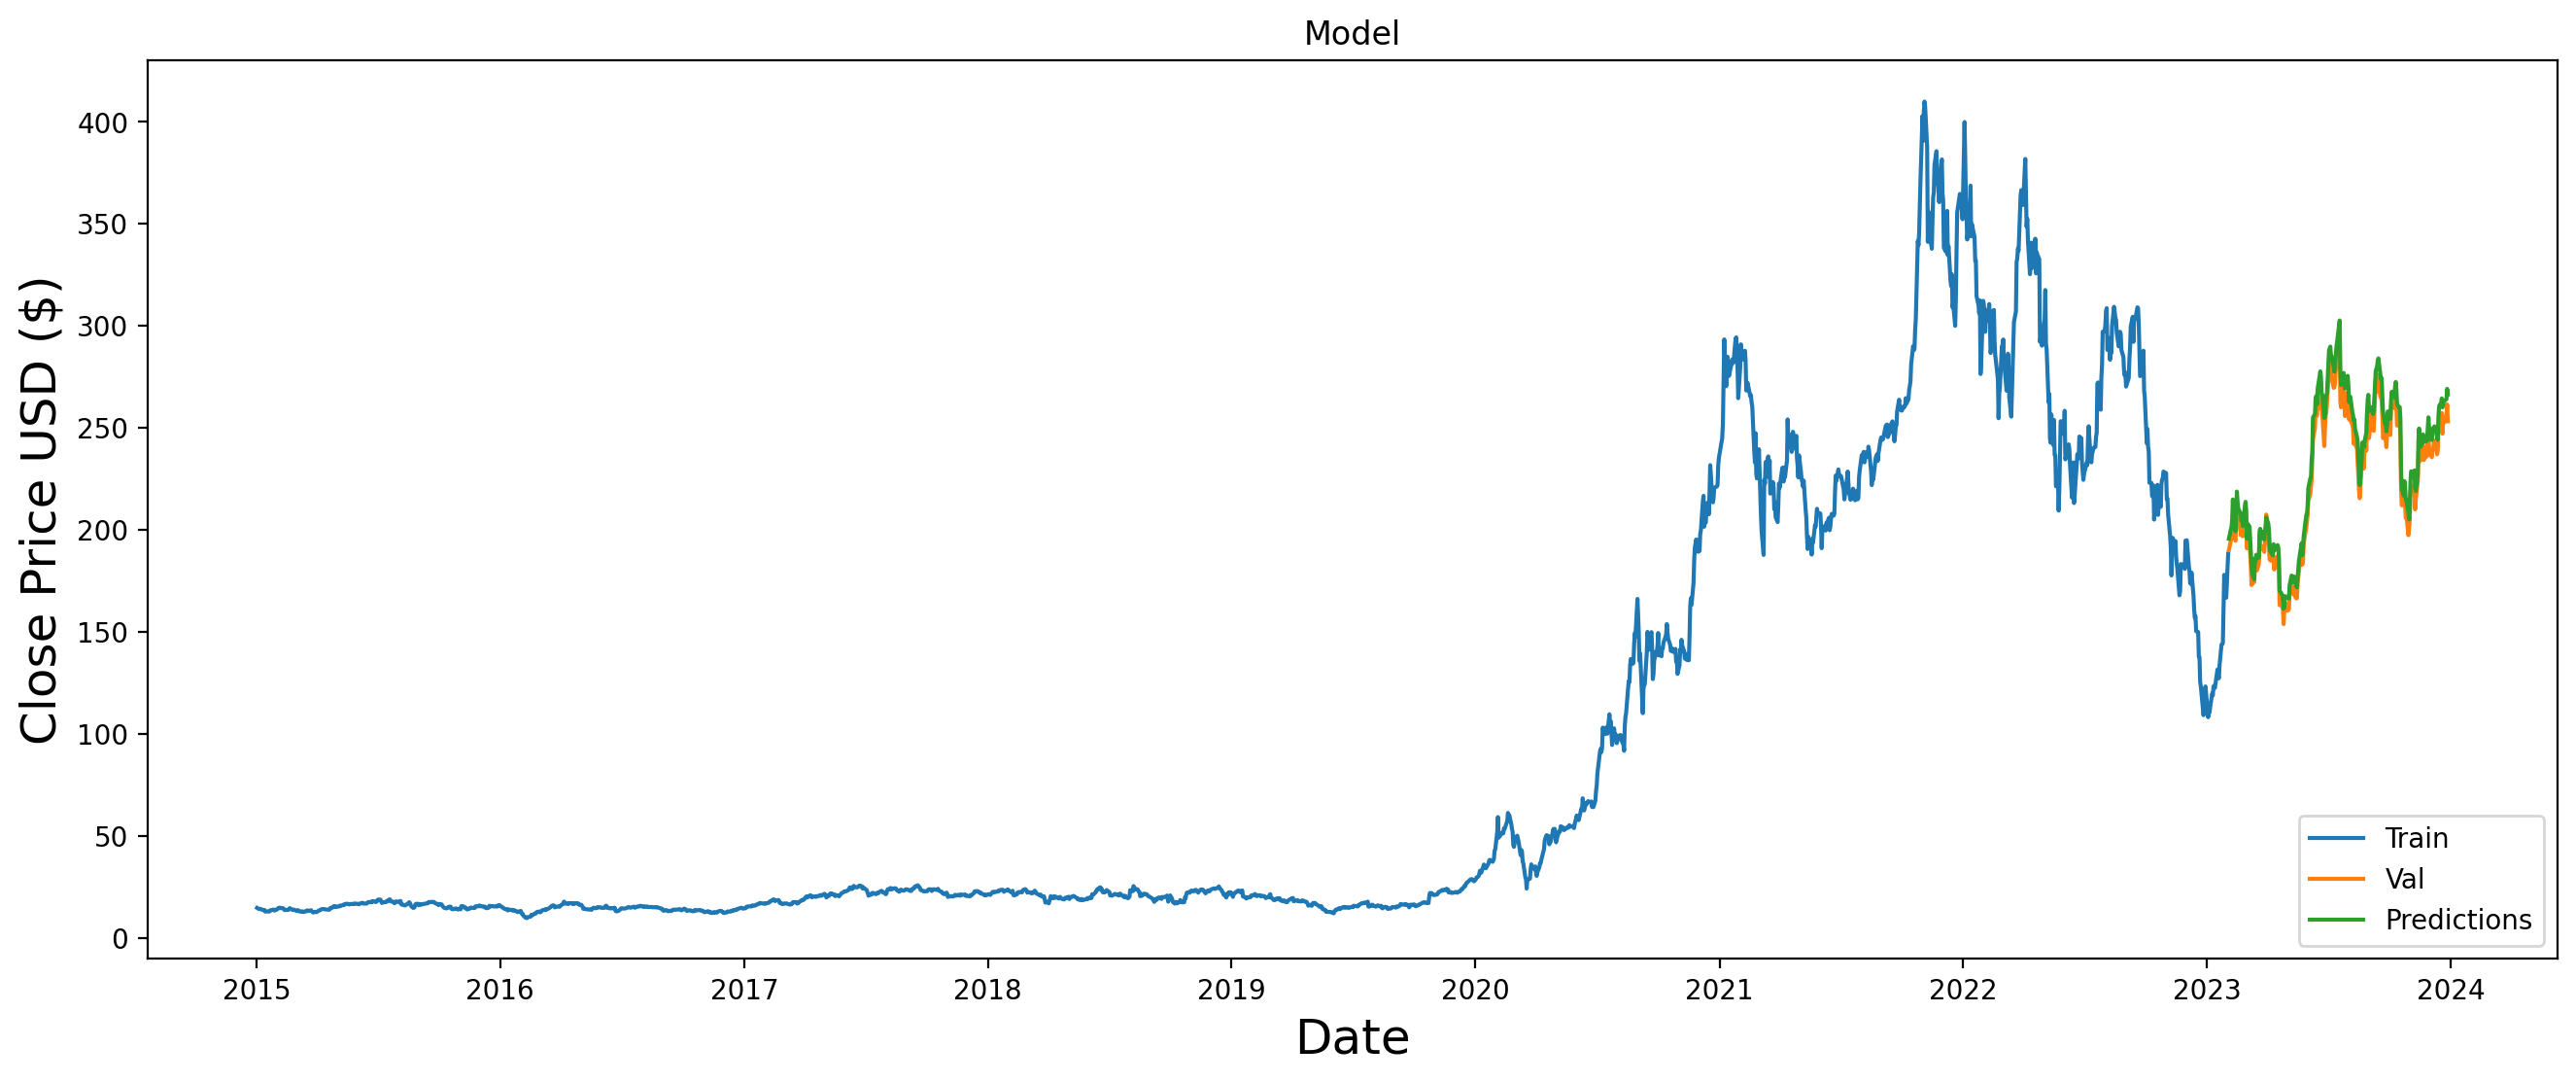

In [ ]:
train = df[['Close_TSLA']][:num_train]
valid = df[['Close_TSLA']][num_train:]
valid['Predictions'] = predictions

plt.figure(figsize = (16,6))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.plot(train['Close_TSLA'])
plt.plot(valid[['Close_TSLA', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()